# Tencent Mobile App Advertising Conversion Rate Estimate

### Background
Computational advertising is one of the most important business models of the Internet, and ad serving is often measured by exposure, clicks, and conversions. Most ad systems are limited by the data reflow of ad performance and can only be optimized by exposure or click as a measure of performance.

Tencent Social Advertising (`http://ads.tencent.com`) leverages the unique capabilities of user identification and conversion tracking data to help advertisers track conversions after an ad is served. The whole process is based on the advertisement conversion data to train the conversion rate prediction model (pCVR, Predicted Conversion Rate), and introduces the pCVR factor in the advertisement ranking to optimize the advertisement serving effect and improve the ROI (return on investment).

### Problem Description
This question uses mobile App ads as the research object to predict the probability of App ads being activated after clicking: pCVR=P(conversion=1 | Ad, User, Context). That is, the probability of activation after an ad clicks, given the ad, user, and context.

### Dataset Features

**ad.csv**： creativeID	adID	camgaignID	advertiserID	appID	appPlatform

**app_categories.csv** ： appID	appCategory

**position.csv** ：positionID	sitesetID	positionType

**user.csv** ：userID	age	gender	education	marriageStatus	haveBaby	hometown	residence

**train.csv** ： label	clickTime	conversionTime	creativeID	userID	positionID	connectionType	telecomsOperator

**test.csv** ：instanceID	label	clickTime	creativeID	userID	positionID	connectionType	telecomsOperator

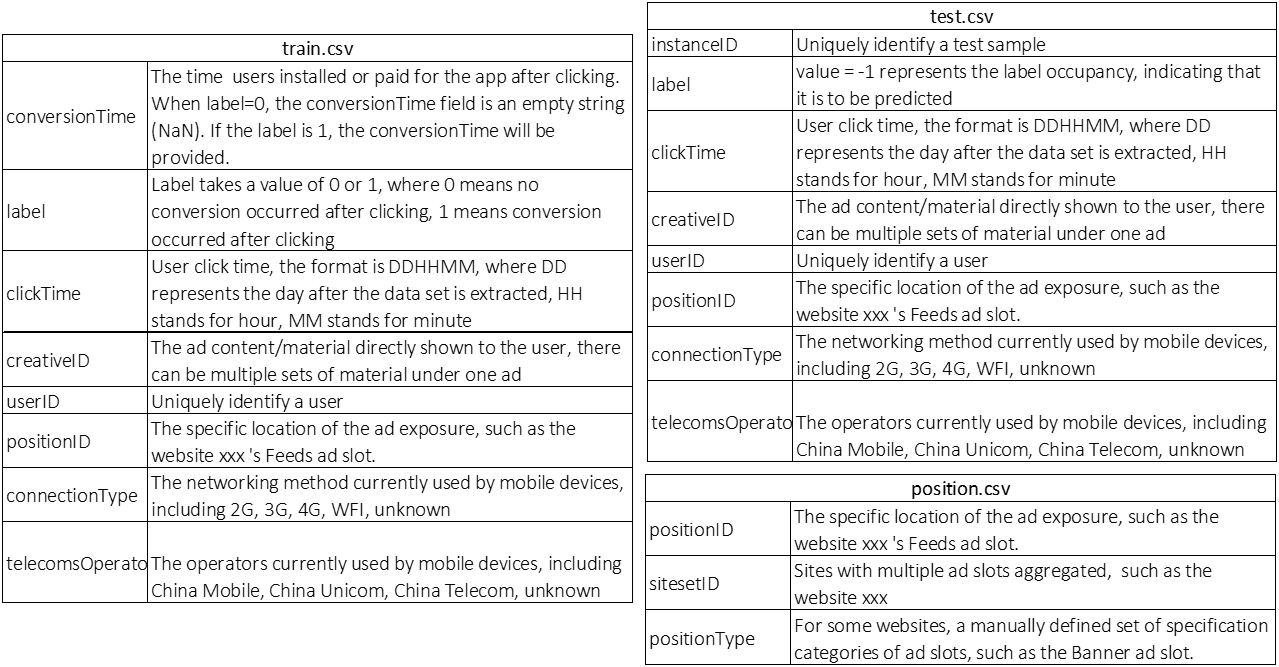

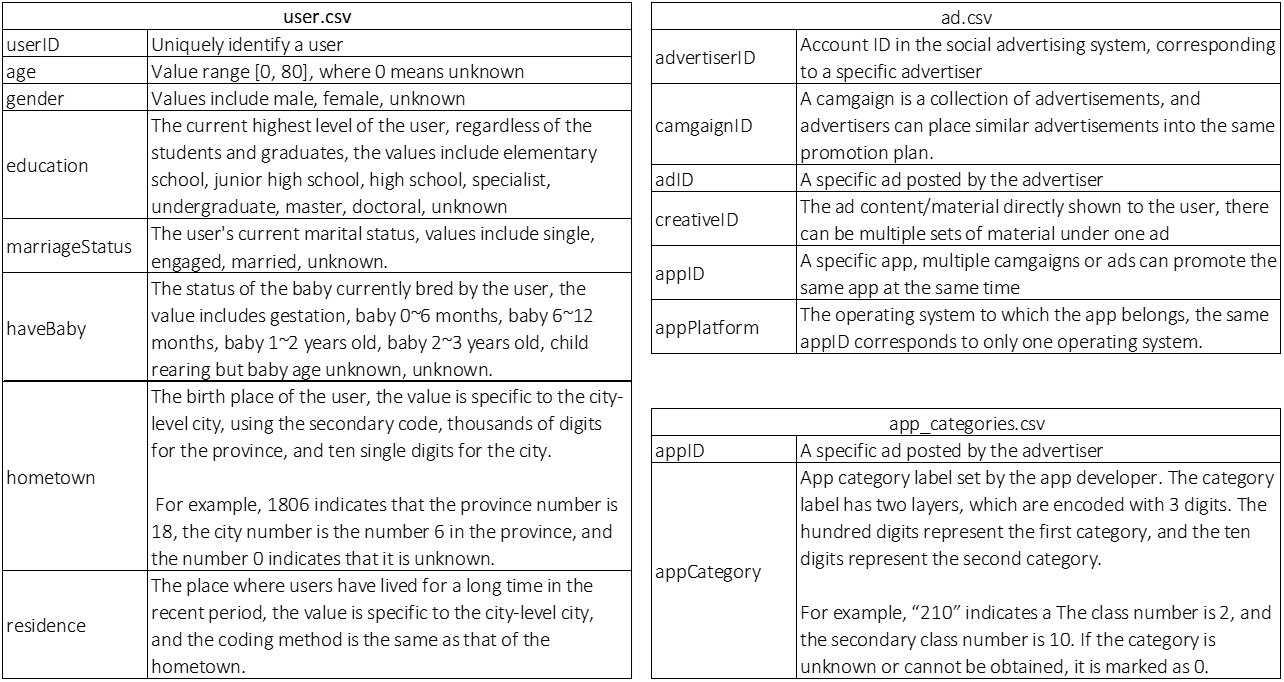

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# data file reading Function
def read_cvs_file(file, logging=False):
    data = pd.read_csv(file)
    if logging:
        print(data.head())
        print("\n data include columns and its unique values as follows: ")
        
        for i, column in enumerate(data.columns.values):
            print("%2d) %-*s %s" % (i, 20, 
                                    column, 
                                    data[column].unique()))
            
        print("\n")
        print(data.describe())
        print("\n")
        print(data.info())
        print("-------------------------------------------------------------------------------------------------------------")
    return data

# Step 1：Data Preprocessing

## ad info processing

In [3]:
# load ad data - no missing data
ad = read_cvs_file("./data/ad.csv", logging=False)
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 6 columns):
creativeID      6582 non-null int64
adID            6582 non-null int64
camgaignID      6582 non-null int64
advertiserID    6582 non-null int64
appID           6582 non-null int64
appPlatform     6582 non-null int64
dtypes: int64(6)
memory usage: 308.6 KB


## app info processing

In [4]:
# Process the app categories data and extract the first level category corresponding to the app
def app_categories_process_first_class(category):
    cate = str(category)
    if len(cate) == 1:
        if int(cate) == 0:
            return 0
        else:
            return int(cate)
    else:
        return int(cate[0])
    
# Process the ad categories data and extract the second level category corresponding to the app
def app_categories_process_second_class(category):
    cate = str(category)
    if len(cate) < 3:
        return 0
    else:
        return int(cate[1:])

In [5]:
# load ad category data
app_categories = read_cvs_file(file="./data/app_categories.csv", logging=False)
app_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217041 entries, 0 to 217040
Data columns (total 2 columns):
appID          217041 non-null int64
appCategory    217041 non-null int64
dtypes: int64(2)
memory usage: 3.3 MB


In [6]:
app_categories["app_categories_first_class"] = app_categories["appCategory"].apply(app_categories_process_first_class)
app_categories["app_categories_second_class"] = app_categories["appCategory"].apply(app_categories_process_second_class)
app_categories.drop(columns=['appCategory'], axis=1, inplace=True)
app_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217041 entries, 0 to 217040
Data columns (total 3 columns):
appID                          217041 non-null int64
app_categories_first_class     217041 non-null int64
app_categories_second_class    217041 non-null int64
dtypes: int64(3)
memory usage: 5.0 MB


## User info processing

In [7]:
user = read_cvs_file(file="./data/user.csv", logging=False)
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805118 entries, 0 to 2805117
Data columns (total 8 columns):
userID            int64
age               int64
gender            int64
education         int64
marriageStatus    int64
haveBaby          int64
hometown          int64
residence         int64
dtypes: int64(8)
memory usage: 171.2 MB


In [8]:
# process province info
def process_province(hometown):
    hometown = str(hometown)
    province = int(hometown[0:2])
    return province

# process city info
def process_city(hometown):
    hometown = str(hometown)
    if len(hometown)>1:
        province = int(hometown[2:])
    else:
        province = 0
    return province

In [9]:
user['hometown_province'] = user['hometown'].apply(process_province)
user['hometown_city'] = user['hometown'].apply(process_city)
user.drop(columns=['hometown'], axis=1, inplace=True)

In [10]:
user['residence_province'] = user['residence'].apply(process_province)
user['residence_city'] = user['residence'].apply(process_city)
user.drop(columns=['residence'], axis=1, inplace=True)

In [11]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2805118 entries, 0 to 2805117
Data columns (total 10 columns):
userID                int64
age                   int64
gender                int64
education             int64
marriageStatus        int64
haveBaby              int64
hometown_province     int64
hometown_city         int64
residence_province    int64
residence_city        int64
dtypes: int64(10)
memory usage: 214.0 MB


# Train data processing

In [12]:
train_data = read_cvs_file("./data/train.csv", logging=False)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3749528 entries, 0 to 3749527
Data columns (total 8 columns):
label               int64
clickTime           int64
conversionTime      float64
creativeID          int64
userID              int64
positionID          int64
connectionType      int64
telecomsOperator    int64
dtypes: float64(1), int64(7)
memory usage: 228.9 MB


In [14]:
# extract day
def get_time_day(t):
    t = str(t)
    t = int(t[0:2])
    return t

# extract hour
def get_time_hour(t):
    t = str(t)
    t=int(t[2:4])
    return t

In [15]:
train_data['clickTime_day'] = train_data['clickTime'].apply(get_time_day)
train_data['clickTime_hour'] = train_data['clickTime'].apply(get_time_hour)
train_data.drop(['clickTime'],axis=1,inplace=True)

In [16]:
#feature- Remove conversionTime because of the strong relationship with label
train_data.drop(['conversionTime'],axis=1,inplace=True)

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3749528 entries, 0 to 3749527
Data columns (total 8 columns):
label               int64
creativeID          int64
userID              int64
positionID          int64
connectionType      int64
telecomsOperator    int64
clickTime_day       int64
clickTime_hour      int64
dtypes: int64(8)
memory usage: 228.9 MB


## position data processing

In [18]:
position = read_cvs_file(file='./data/position.csv', logging=False)
position.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7645 entries, 0 to 7644
Data columns (total 3 columns):
positionID      7645 non-null int64
sitesetID       7645 non-null int64
positionType    7645 non-null int64
dtypes: int64(3)
memory usage: 179.3 KB


## Merge data together

In [19]:
# Merge training set and user information by userID
merged_data = pd.merge(train_data, user, on='userID', how="inner")

# Merge training set and ad information by creativeID   
merged_data = pd.merge(merged_data, ad, on='creativeID', how="inner")

# Merge training set and app information by appID
merged_data = pd.merge(merged_data, app_categories, on='appID', how="inner")
    
# Merge training set and ad position information by positionID
merged_data = pd.merge(merged_data, position, on='positionID', how="inner")

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749528 entries, 0 to 3749527
Data columns (total 26 columns):
label                          int64
creativeID                     int64
userID                         int64
positionID                     int64
connectionType                 int64
telecomsOperator               int64
clickTime_day                  int64
clickTime_hour                 int64
age                            int64
gender                         int64
education                      int64
marriageStatus                 int64
haveBaby                       int64
hometown_province              int64
hometown_city                  int64
residence_province             int64
residence_city                 int64
adID                           int64
camgaignID                     int64
advertiserID                   int64
appID                          int64
appPlatform                    int64
app_categories_first_class     int64
app_categories_second_class    int64

In [20]:
# int8: -128 to 127 ; int16:-32,768 to +32,767 ; int32:-2147,483,648 to 2147483647
merged_data.describe()

# userID 

,label,creativeID,userID,positionID,connectionType,telecomsOperator,clickTime_day,clickTime_hour,age,gender,...,residence_city,adID,camgaignID,advertiserID,appID,appPlatform,app_categories_first_class,app_categories_second_class,sitesetID,positionType
count,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,...,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06,3.749528e+06
mean,2.487300e-02,3.261575e+03,1.405349e+06,3.702799e+03,1.222590e+00,1.605879e+00,2.403944e+01,1.407959e+01,2.011426e+01,1.284243e+00,...,3.560234e+00,2.005435e+03,4.155907e+02,2.776200e+01,3.703212e+02,1.217947e+00,2.013660e+00,5.851555e+00,2.934479e-01,8.044047e-01
std,1.557380e-01,1.829643e+03,8.088094e+05,1.923724e+03,5.744428e-01,8.491127e-01,3.954420e+00,6.010851e+00,1.187724e+01,6.597284e-01,...,3.020678e+00,1.250836e+03,2.134300e+02,3.274570e+01,1.440570e+02,4.128515e-01,7.748193e-01,3.682285e+00,4.718961e-01,6.385933e-01
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.540000e+03,7.058698e+05,2.579000e+03,1.000000e+00,1.000000e+00,2.100000e+01,1.000000e+01,1.300000e+01,1.000000e+00,...,1.000000e+00,7.610000e+02,2.050000e+02,3.000000e+00,3.600000e+02,1.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,3.465000e+03,1.407062e+06,3.322000e+03,1.000000e+00,1.000000e+00,2.400000e+01,1.500000e+01,1.900000e+01,1.000000e+00,...,3.000000e+00,1.977000e+03,4.600000e+02,3.000000e+00,4.650000e+02,1.000000e+00,2.000000e+00,9.000000e+00,0.000000e+00,1.000000e+00
75%,0.000000e+00,4.565000e+03,2.105989e+06,4.896000e+03,1.000000e+00,2.000000e+00,2.700000e+01,1.900000e+01,2.700000e+01,2.000000e+00,...,6.000000e+00,3.242000e+03,6.320000e+02,5.600000e+01,4.650000e+02,1.000000e+00,2.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00
max,1.000000e+00,6.582000e+03,2.805118e+06,7.645000e+03,4.000000e+00,3.000000e+00,3.000000e+01,2.300000e+01,8.000000e+01,2.000000e+00,...,1.800000e+01,3.616000e+03,7.200000e+02,9.100000e+01,4.720000e+02,2.000000e+00,5.000000e+00,9.000000e+00,2.000000e+00,5.000000e+00


In [21]:
userId_S = pd.DataFrame(merged_data['userID'], dtype='int32') 
camgaignID_S = pd.DataFrame(merged_data['camgaignID'], dtype='int16')
adID_S = pd.DataFrame(merged_data['adID'], dtype='int16')
positionID_S = pd.DataFrame(merged_data['positionID'], dtype='int16')
creativeID_S = pd.DataFrame(merged_data['creativeID'], dtype='int16')

In [22]:
merged_data_compress = pd.DataFrame(merged_data, dtype='int8')
merged_data_compress['userID'] = userId_S
merged_data_compress['camgaignID'] = camgaignID_S
merged_data_compress['adID'] = adID_S
merged_data_compress['positionID'] = positionID_S
merged_data_compress['creativeID'] = creativeID_S

In [23]:
merged_data_compress.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749528 entries, 0 to 3749527
Data columns (total 26 columns):
label                          int8
creativeID                     int16
userID                         int32
positionID                     int16
connectionType                 int8
telecomsOperator               int8
clickTime_day                  int8
clickTime_hour                 int8
age                            int8
gender                         int8
education                      int8
marriageStatus                 int8
haveBaby                       int8
hometown_province              int8
hometown_city                  int8
residence_province             int8
residence_city                 int8
adID                           int16
camgaignID                     int16
advertiserID                   int8
appID                          int8
appPlatform                    int8
app_categories_first_class     int8
app_categories_second_class    int8
sitesetID         

In [24]:
print(merged_data['userID'].unique().shape)
print(merged_data['creativeID'].unique().shape)
print(merged_data['appID'].unique().shape)
print(merged_data['positionID'].unique().shape)
print(merged_data['camgaignID'].unique().shape)
print(merged_data['advertiserID'].unique().shape)

(2595627,)
(6315,)
(50,)
(7219,)
(677,)
(89,)


In [ ]:
# train_user_ad_app_pos.drop(axis=1, columns=['creativeID', 'userID', 'appID', 'positionID'])

In [ ]:
merged_data_compress.columns

# Step 2: Feature Enginnering

## Separate data and labels

In [26]:
# feature part
X = merged_data_compress.iloc[:,1:]

In [27]:
# label part
y = merged_data_compress.loc[:,['label']] # columns Series

## Random forest modeling && feature importance ranking

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
forest = RandomForestClassifier(n_estimators=100,
                                random_state=0,
                                n_jobs=-1)

In [31]:
forest.fit(X.values, y.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [32]:
feat_labels = X.columns
feat_labels

Index(['creativeID', 'userID', 'positionID', 'connectionType',
       'telecomsOperator', 'clickTime_day', 'clickTime_hour', 'age', 'gender',
       'education', 'marriageStatus', 'haveBaby', 'hometown_province',
       'hometown_city', 'residence_province', 'residence_city', 'adID',
       'camgaignID', 'advertiserID', 'appID', 'appPlatform',
       'app_categories_first_class', 'app_categories_second_class',
       'sitesetID', 'positionType'],
      dtype='object')

In [33]:
importances = forest.feature_importances_
importances

array([0.02557551, 0.17113458, 0.06481588, 0.00436067, 0.03453989,
       0.076338  , 0.09405691, 0.0875135 , 0.01321131, 0.05031221,
       0.03113971, 0.01879074, 0.06247256, 0.05239632, 0.0843336 ,
       0.06762492, 0.01733232, 0.01335282, 0.00610102, 0.00581847,
       0.0008678 , 0.00270089, 0.00731277, 0.00282943, 0.00506817])

In [34]:
indices = np.argsort(importances)[::-1]
indices

array([ 1,  6,  7, 14,  5, 15,  2, 12, 13,  9,  4, 10,  0, 11, 16, 17,  8,
       22, 18, 19, 24,  3, 23, 21, 20], dtype=int64)

In [36]:
for f in range(X.values.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) userID                         0.171135
 2) clickTime_hour                 0.094057
 3) age                            0.087514
 4) residence_province             0.084334
 5) clickTime_day                  0.076338
 6) residence_city                 0.067625
 7) positionID                     0.064816
 8) hometown_province              0.062473
 9) hometown_city                  0.052396
10) education                      0.050312
11) telecomsOperator               0.034540
12) marriageStatus                 0.031140
13) creativeID                     0.025576
14) haveBaby                       0.018791
15) adID                           0.017332
16) camgaignID                     0.013353
17) gender                         0.013211
18) app_categories_second_class    0.007313
19) advertiserID                   0.006101
20) appID                          0.005818
21) positionType                   0.005068
22) connectionType                 0.004361
23) sitesetID                   

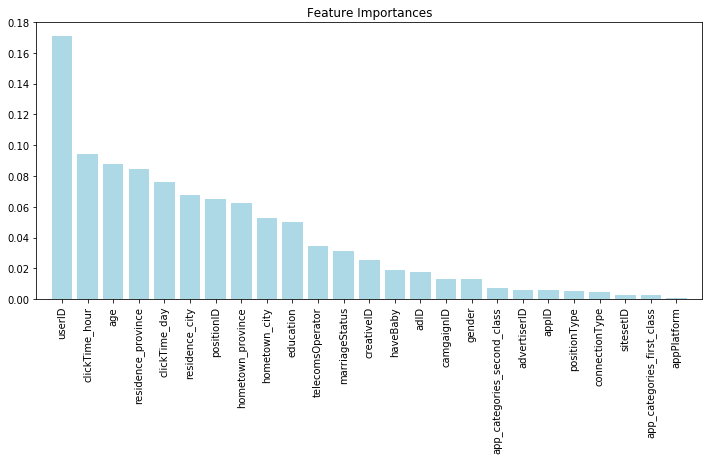

In [38]:
plt.figure(figsize=(10, 6.5)) # 1000 * 650
plt.title('Feature Importances')
plt.bar(range(X.values.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X.values.shape[1]), 
           feat_labels[indices], rotation=90)

plt.xlim([-1, X.values.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

## Performing one-hot encoding on nominal features

### Batch processing features function

In [28]:
# Batch processing attribute requireing one-hot encoding  (accepting binning)
def batch_get_dummies(df, f_list, bins=None):
    dummies_f = None
    for f in f_list:
        if(bins and (f in bins)):
            dummies_f = pd.get_dummies(pd.cut(df[f], bins[f], right=False), prefix=f, dtype='int8')
        else:
            dummies_f = pd.get_dummies(df[f], prefix=f, dtype='int8')
        
        df = pd.concat([df,dummies_f],axis=1)
        df.drop([f],axis=1, inplace=True)
    
    return df

### Analyze the age distribution

In [40]:
age_distribution = user.age.value_counts(sort=False)

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

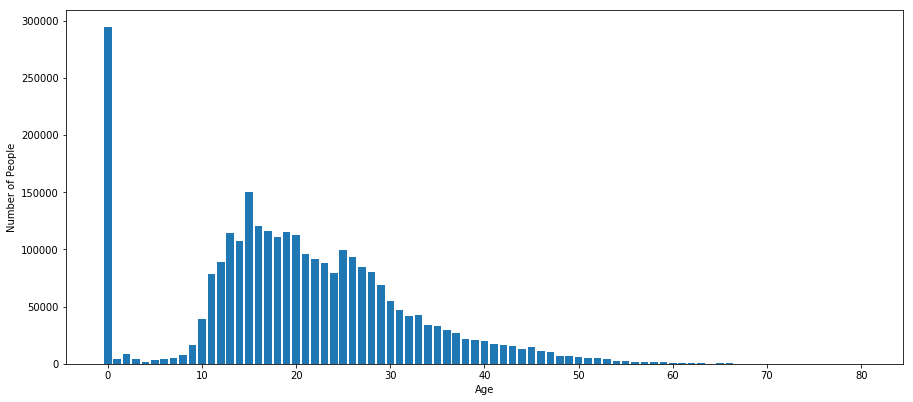

In [42]:
plt.figure(figsize=(15, 6.5)) # 1500 * 650
plt.bar(age_distribution.index, age_distribution.values)
plt.xlabel("Age")
plt.ylabel("Number of People")
plt.show()

## One-hot encoding processing

In [1]:
age_bins = [0,1,10,20,30,40,50,60,70,90]
hour_bins = [0,7,9,12,14,18,25] # use 25 for including 24

In [30]:
feature_list = ['age','gender', 'marriageStatus', 'hometown_province', 'hometown_city','residence_province', 
                'residence_city', 'app_categories_second_class','app_categories_first_class', 'telecomsOperator',
                'connectionType','sitesetID', 'positionType']

bins = {'age' : age_bins, 'clickTime_hour' : hour_bins}

In [31]:
X_dummies = batch_get_dummies(X, bins=bins, f_list=feature_list)
X_dummies.head()

,creativeID,userID,positionID,clickTime_day,clickTime_hour,education,haveBaby,adID,camgaignID,advertiserID,...,connectionType_4,sitesetID_0,sitesetID_1,sitesetID_2,positionType_0,positionType_1,positionType_2,positionType_3,positionType_4,positionType_5
0,3089,2798058,293,17,0,1,1,1321,83,10,...,0,1,0,0,0,0,0,1,0,0
1,3089,1683269,293,18,0,0,0,1321,83,10,...,0,1,0,0,0,0,0,1,0,0
2,3089,240899,293,19,10,1,0,1321,83,10,...,0,1,0,0,0,0,0,1,0,0
3,2230,2177495,293,18,23,1,1,2841,83,10,...,0,1,0,0,0,0,0,1,0,0
4,2230,417301,293,20,1,0,1,2841,83,10,...,0,1,0,0,0,0,0,1,0,0


In [46]:
X_dummies.columns

Index(['creativeID', 'userID', 'positionID', 'clickTime_day', 'clickTime_hour',
       'education', 'haveBaby', 'adID', 'camgaignID', 'advertiserID',
       ...
       'connectionType_4', 'sitesetID_0', 'sitesetID_1', 'sitesetID_2',
       'positionType_0', 'positionType_1', 'positionType_2', 'positionType_3',
       'positionType_4', 'positionType_5'],
      dtype='object', length=175)

### The original data set is too large, which leads to memory overflow and showing MemoryError when processing；Therefore, I will conduct stratified sampling and reduce the quantity on the original data set according to the category proportion of the original data set

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_Sampled, X_unused, y_Sampled, y_unused = train_test_split(X_dummies, y,
                                                 test_size=0.4,
                                                 random_state=0,
                                                 stratify=y)

In [34]:
X_Sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2249716 entries, 758268 to 1357484
Columns: 175 entries, creativeID to positionType_5
dtypes: int16(4), int32(1), int8(170)
memory usage: 407.6 MB


## Partitioning a dataset into separate training and test sets(holdout method)

In [50]:
# stratify ensures that both training and test datasets have the same class proportions as the original dataset
X_train, X_test, y_train, y_test = train_test_split(X_Sampled, y_Sampled,
                                                 test_size=0.4,
                                                 random_state=0,
                                                 stratify=y_Sampled)

In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1349829 entries, 1763393 to 1711162
Columns: 175 entries, creativeID to positionType_5
dtypes: int16(4), int32(1), int8(170)
memory usage: 244.6 MB


In [52]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899887 entries, 3672702 to 3522917
Columns: 175 entries, creativeID to positionType_5
dtypes: int16(4), int32(1), int8(170)
memory usage: 163.1 MB


# Step 3 ：Model Building

## Streamlining workflows with pipelines

In [56]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [57]:
pipe_lr = make_pipeline(LogisticRegression(random_state=1, penalty='l2'))

## K-fold cross-validation

### First aspect

In [58]:
from sklearn.model_selection import StratifiedKFold

In [59]:
X_train_np = X_train.values
y_train_np = y_train.values.ravel()

kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train_np, y_train_np)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train_np[train], y_train_np[train])
    score = pipe_lr.score(X_train_np[test], y_train_np[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train_np[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


Fold:  1, Class dist.: [1184629   30216], Acc: 0.975
Fold:  2, Class dist.: [1184629   30216], Acc: 0.975
Fold:  3, Class dist.: [1184629   30216], Acc: 0.975
Fold:  4, Class dist.: [1184629   30216], Acc: 0.975
Fold:  5, Class dist.: [1184629   30217], Acc: 0.975
Fold:  6, Class dist.: [1184630   30217], Acc: 0.975
Fold:  7, Class dist.: [1184630   30217], Acc: 0.975
Fold:  8, Class dist.: [1184630   30217], Acc: 0.975
Fold:  9, Class dist.: [1184630   30217], Acc: 0.975
Fold: 10, Class dist.: [1184630   30217], Acc: 0.975

CV accuracy: 0.975 +/- 0.000


### Second aspect

In [60]:
from sklearn.model_selection import cross_val_score

In [61]:
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train_np,
                         y=y_train_np,
                         cv=5,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.9751265  0.9751265  0.9751265  0.9751265  0.97513011]
CV accuracy: 0.975 +/- 0.000


## test X_test to get accuracy score

In [62]:
y_model_lr = pipe_lr.predict(X_test.values)
from sklearn.metrics import accuracy_score
accuracy_score(y_test.values, y_model_lr)

0.9751268770412285

# Step 4 ：Model Evaluation

## Diagnosing bias and variance problems with learning curves

detect whether the model suffers from high variance or high bias, and whether the collection of more
data could help address this problem

In [63]:
from sklearn.model_selection import learning_curve

In [72]:
# use 10 evenly spaced, relative intervals for the training set sizes
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                       X=X_train_np,
                                                       y=y_train_np,
                                                       train_sizes=np.linspace(0.1, 1.0, 10), 
                                                       cv=3,
                                                       n_jobs=1)

In [73]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

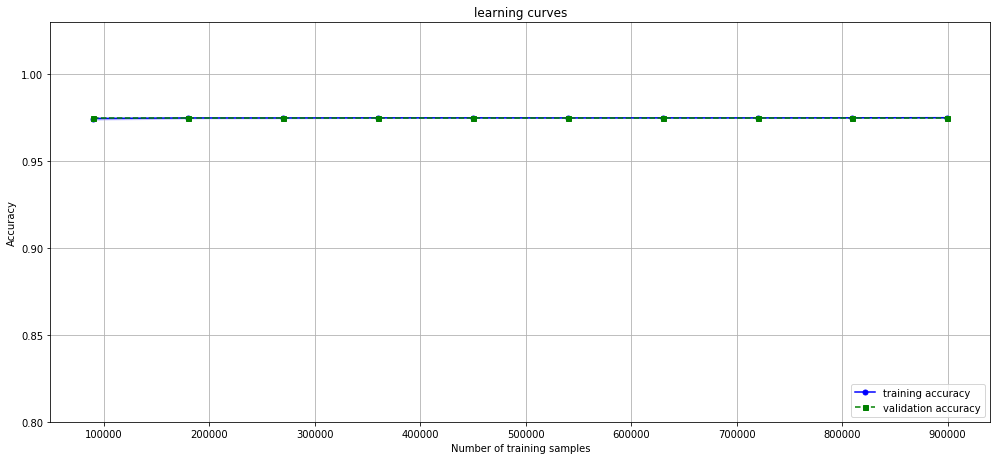

In [74]:
plt.figure(figsize=(14, 6.5)) # 1400 * 650
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.title('learning curves')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

## Addressing over- or underfitting with validation curves

Validation curves are a useful tool for improving the performance of a model by addressing issues such as overfitting or underfitting. Validation curves are related to learning curves, but instead of plotting the training and test accuracies as functions of the sample size, we vary the values of the model parameters.

In [75]:
from sklearn.model_selection import validation_curve

In [76]:
lr_C_param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [78]:
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train_np, 
                y=y_train_np, 
                param_name='logisticregression__C', 
                param_range=lr_C_param_range,
                cv=3)

In [80]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

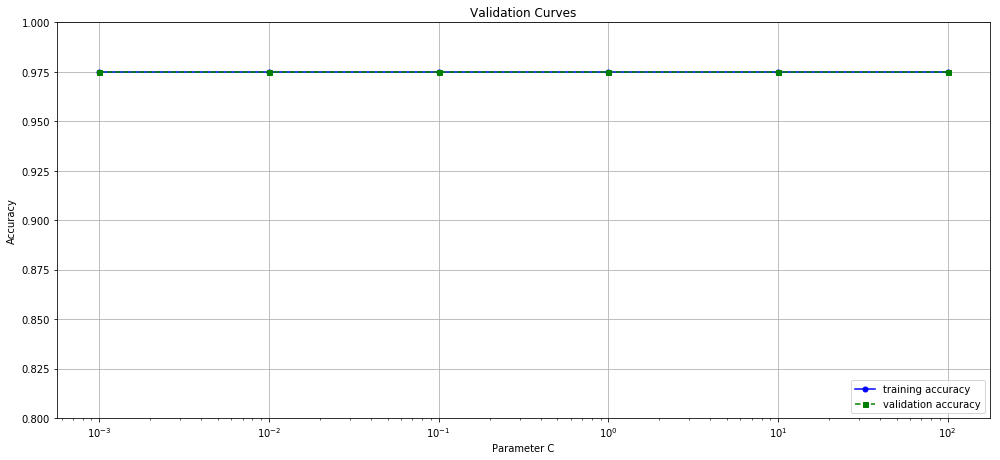

In [82]:
plt.figure(figsize=(14, 6.5)) # 1400 * 650
plt.plot(lr_C_param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(lr_C_param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(lr_C_param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(lr_C_param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.title('Validation Curves')
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

## Confusion Matrix

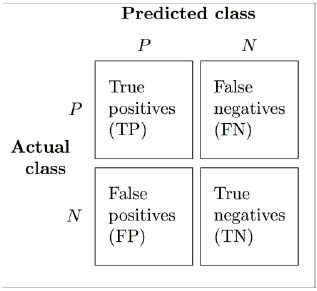

In [88]:
y_test_np = y_test.values.ravel()

In [79]:
from sklearn.metrics import confusion_matrix

In [83]:
y_pred_lr = pipe_lr.predict(X_test.values)
confmat = confusion_matrix(y_true=y_test_np, y_pred=y_pred_lr)

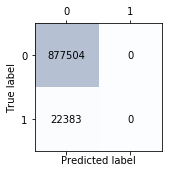

In [84]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

In [85]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [89]:
print('Precision: %.3f' % precision_score(y_true=y_test_np, y_pred=y_pred_lr))
print('Recall: %.3f' % recall_score(y_true=y_test_np, y_pred=y_pred_lr))
print('F1 Score: %.3f' % f1_score(y_true=y_test_np, y_pred=y_pred_lr))

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.000
Recall: 0.000
F1 Score: 0.000


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Class imbalance data

In [90]:
positive_num = y_Sampled[y_Sampled['label']==1].values.shape[0]
negative_num = y_Sampled[y_Sampled['label']==0].values.shape[0]

negative_num/float(positive_num)

39.20437121361045

training a model on such a dataset that achieves approximately 97.5 percent test accuracy would mean our model hasn't learned anything useful from the features provided in this dataset

## the upsampling of the minority class by drawing new samples from the dataset with replacement

In [35]:
from sklearn.utils import resample

In [36]:
y_Sampled_np = y_Sampled.values.ravel()
X_Sampled_np = X_Sampled.values

In [37]:
X_upsampled, y_upsampled = resample(X_Sampled_np[y_Sampled_np == 1],
                                    y_Sampled_np[y_Sampled_np == 1],
                                    replace=True,
                                    n_samples=X_Sampled_np[y_Sampled_np == 0].shape[0],
                                    random_state=123)

In [38]:
X_bal = np.vstack((X_Sampled_np[y_Sampled_np == 0], X_upsampled))
y_bal = np.hstack((y_Sampled_np[y_Sampled_np == 0], y_upsampled))

In [100]:
positive_num = y_bal[y_bal == 1].shape[0]
negative_num = y_bal[y_bal == 0].shape[0]

negative_num/float(positive_num)

1.0

In [39]:
X_bal.shape

(4387518, 175)

# Step5：Model optimization

## Repeated Data Processing

In [41]:
X_bal_pd = pd.DataFrame(X_bal)
y_bal_pd = pd.DataFrame(y_bal)
bal_pd = pd.concat([X_bal_pd, y_bal_pd], axis=1)

In [42]:
bal_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4387518 entries, 0 to 4387517
Columns: 176 entries, 0 to 0
dtypes: int32(175), int8(1)
memory usage: 2.9 GB


In [45]:
bal_sampled = bal_pd.sample(frac=0.1)

In [46]:
bal_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438752 entries, 2162470 to 468981
Columns: 176 entries, 0 to 0
dtypes: int32(175), int8(1)
memory usage: 296.7 MB


In [51]:
# feature part
X_bal = bal_sampled.iloc[:,1:].values
# label part
y_bal = bal_sampled.iloc[:,-1].values.ravel() # columns Series

In [54]:
positive_num = y_bal[y_bal == 1].shape[0]
negative_num = y_bal[y_bal == 0].shape[0]

negative_num/float(positive_num)

0.9980964091354145

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal,
                                                 test_size=0.4,
                                                 random_state=0,
                                                 stratify=y_bal)

## Repeated Model Building and Training

In [61]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

pipe_lr_new = make_pipeline(LogisticRegression(random_state=1, penalty='l2'))

In [62]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr_new,
                         X=X_train,
                         y=y_train,
                         cv=5,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [1. 1. 1. 1. 1.]
CV accuracy: 1.000 +/- 0.000


In [64]:
rf = RandomForestClassifier(n_estimators=100, max_features=0.6)

scores = cross_val_score(estimator=rf,
                         X=X_train,
                         y=y_train,
                         cv=5,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.9326315  0.9326315  0.9323128  0.9324512  0.9326315]
CV accuracy:0.932 +/-0.000


## Fine-tuning machine learning models via grid search

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
              #'n_estimators': [100],
              'n_estimators': [10, 100, 500, 1000],
              'max_features':[0.6, 0.7, 0.8, 0.9]
             }

rf = RandomForestClassifier()
rfc = GridSearchCV(rf, param_grid, scoring = 'neg_log_loss', cv=3, n_jobs=2)
rfc.fit(X_train, y_train)

print(rfc.best_score_)
print(rfc.best_params_)

# Step 6 ：Prediction from New data

## use test data provided to test Classifiers

In [74]:
test_data = read_cvs_file("./data/test.csv", logging=False)
#test_data.info()

test_data['clickTime_day'] = test_data['clickTime'].apply(get_time_day)
test_data['clickTime_hour'] = test_data['clickTime'].apply(get_time_hour)
test_data.drop(['clickTime'],axis=1,inplace=True)

test_data_clean = test_data.iloc[:,2:]
test_data_clean.head()

# Merge training set and user information by userID
merged_data = pd.merge(test_data_clean, user, on='userID', how="inner")

# Merge training set and ad information by creativeID   
merged_data = pd.merge(merged_data, ad, on='creativeID', how="inner")

# Merge training set and app information by appID
merged_data = pd.merge(merged_data, app_categories, on='appID', how="inner")
    
# Merge training set and ad position information by positionID
merged_data = pd.merge(merged_data, position, on='positionID', how="inner")

# merged_data.info()

In [73]:
# feature part
X = merged_data.iloc[:,1:]

X_test_dummies = batch_get_dummies(X, bins=bins, f_list=feature_list)

x_test_np = np.array(X_test_dummies,dtype='int32')

x_test_np.shape

(338489, 172)

In [ ]:
result_predict_prob = []
result_predict=[]
clfs = [rf, pipe_lr_new]
scale = len(clfs)

for i in range(scale):
    result_indiv = clfs[i].predict(x_test_np)
    result_indiv_proba = clfs[i].predict_proba(x_test_np)[:,1]
    result_predict.append(result_indiv)
    result_predict_prob.append(result_indiv_proba)


result_predict_prob = np.reshape(result_predict_prob,[-1,scale])
result_predict = np.reshape(result_predict,[-1,scale])

result_predict_prob = np.mean(result_predict_prob,axis=1)
result_predict = max_count(result_predict)


result_predict_prob = np.array(result_predict_prob).reshape([-1,1])


test_data['prob'] = result_predict_prob
test_data = test_data.loc[:,['instanceID','prob']]
test_data.to_csv('predict.csv',index=False)

print("prediction done!")